In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *
from fastai.dataset import *
from fastai.structured import *
from fastai.column_data import *

from math import ceil

from dateutil import parser

torch.cuda.set_device(0)

In [2]:
PATH = "data/"
sz=224
arch=resnext101_64
batch_size=5

## Exploratory Analysis and Feature Engineering

In [3]:
!ls {PATH}

item_categories.csv  sample_submission.csv     test.csv
items.csv	     sample_submission.csv.gz  test.csv.gz
sales_train.csv      shops.csv


In [4]:
sample_subm = pd.read_csv(f'{PATH}sample_submission.csv')
display(sample_subm.tail())

,ID,item_cnt_month
214195,214195,0.5
214196,214196,0.5
214197,214197,0.5
214198,214198,0.5
214199,214199,0.5


In [5]:
item_categories = pd.read_csv(f'{PATH}item_categories.csv')
items = pd.read_csv(f'{PATH}items.csv')
shops = pd.read_csv(f'{PATH}shops.csv')
train = pd.read_csv(f'{PATH}sales_train.csv')
test = pd.read_csv(f'{PATH}test.csv')

In [6]:
#Make Monthly
train['date'] = pd.to_datetime(train['date'], format='%d.%m.%Y')
train['month'] = train['date'].dt.month
train['year'] = train['date'].dt.year
train = train.drop(['date'], axis=1)
train = train.groupby([c for c in train.columns if c not in ['item_cnt_day']], as_index=False)[['item_cnt_day']].sum()
train = train.rename(columns={'item_cnt_day':'item_cnt_month'})
#Monthly Mean
shop_item_monthly_mean = train[['shop_id','item_id','item_cnt_month']].groupby(['shop_id','item_id'], as_index=False)[['item_cnt_month']].mean()
shop_item_monthly_mean = shop_item_monthly_mean.rename(columns={'item_cnt_month':'item_cnt_month_mean'})
#Add Mean Feature
train = pd.merge(train, shop_item_monthly_mean, how='left', on=['shop_id','item_id'])
#Last Month (Oct 2015)
shop_item_prev_month = train[train['date_block_num']==33][['shop_id','item_id','item_cnt_month']]
shop_item_prev_month = shop_item_prev_month.rename(columns={'item_cnt_month':'item_cnt_prev_month'})
shop_item_prev_month.head()
#Add Previous Month Feature
train = pd.merge(train, shop_item_prev_month, how='left', on=['shop_id','item_id']).fillna(0.)
#Items features
train = pd.merge(train, items, how='left', on='item_id')
#Item Category features
train = pd.merge(train, item_categories, how='left', on='item_category_id')
#Shops features
train = pd.merge(train, shops, how='left', on='shop_id')
train.head()

,date_block_num,shop_id,item_id,item_price,month,year,item_cnt_month,item_cnt_month_mean,item_cnt_prev_month,item_name,item_category_id,item_category_name,shop_name
0,0,0,32,221.0,1,2013,6.0,8.000000,0.0,1+1,40,Кино - DVD,"!Якутск Орджоникидзе, 56 фран"
1,0,0,33,347.0,1,2013,3.0,3.000000,0.0,1+1 (BD),37,Кино - Blu-Ray,"!Якутск Орджоникидзе, 56 фран"
2,0,0,35,247.0,1,2013,1.0,7.500000,0.0,10 ЛЕТ СПУСТЯ,40,Кино - DVD,"!Якутск Орджоникидзе, 56 фран"
3,0,0,43,221.0,1,2013,1.0,1.000000,0.0,100 МИЛЛИОНОВ ЕВРО,40,Кино - DVD,"!Якутск Орджоникидзе, 56 фран"
4,0,0,51,127.0,1,2013,1.0,1.666667,0.0,100 лучших произведений классики (mp3-CD) (Dig...,57,Музыка - MP3,"!Якутск Орджоникидзе, 56 фран"


In [7]:
test = test.drop('ID', axis=1)

In [8]:
test['month'] = 11
test['year'] = 2015
test['date_block_num'] = 34
#Add Mean Feature
test = pd.merge(test, shop_item_monthly_mean, how='left', on=['shop_id','item_id']).fillna(0.)
#Add Previous Month Feature
test = pd.merge(test, shop_item_prev_month, how='left', on=['shop_id','item_id']).fillna(0.)
#Items features
test = pd.merge(test, items, how='left', on='item_id')
#Item Category features
test = pd.merge(test, item_categories, how='left', on='item_category_id')
#Shops features
test = pd.merge(test, shops, how='left', on='shop_id')
test['item_cnt_month'] = 0.
test.head()

,shop_id,item_id,month,year,date_block_num,item_cnt_month_mean,item_cnt_prev_month,item_name,item_category_id,item_category_name,shop_name,item_cnt_month
0,5,5037,11,2015,34,1.181818,0.0,"NHL 15 [PS3, русские субтитры]",19,Игры - PS3,"Вологда ТРЦ ""Мармелад""",0.0
1,5,5320,11,2015,34,0.000000,0.0,ONE DIRECTION Made In The A.M.,55,Музыка - CD локального производства,"Вологда ТРЦ ""Мармелад""",0.0
2,5,5233,11,2015,34,1.428571,1.0,"Need for Speed Rivals (Essentials) [PS3, русск...",19,Игры - PS3,"Вологда ТРЦ ""Мармелад""",0.0
3,5,5232,11,2015,34,1.000000,0.0,"Need for Speed Rivals (Classics) [Xbox 360, ру...",23,Игры - XBOX 360,"Вологда ТРЦ ""Мармелад""",0.0
4,5,5268,11,2015,34,0.000000,0.0,"Need for Speed [PS4, русская версия]",20,Игры - PS4,"Вологда ТРЦ ""Мармелад""",0.0


In [9]:
price = train.reset_index().set_index(
    ['item_id', 'shop_id', 'date_block_num']).sort_index()[['item_price', 'item_cnt_month']]
price.head()

item_price  item_cnt_month
item_id shop_id date_block_num                            
0       54      20                    58.0             1.0
1       55      15                  4490.0             2.0
                18                  4490.0             1.0
                19                  4490.0             1.0
                20                  4490.0             1.0

In [10]:
# Helpers
def closest_date_block(current_day, item_id, shop_id):
    """Find the block_date which is closest to the current_day, given item_id and shop_id. Returns index integer"""
    if (item_id, shop_id) in price.index:
        search_lst = np.array(price.loc[(item_id, shop_id)].index)        
        return search_lst[np.abs(current_day - search_lst).argmin()]
    return -1
                
def closest_price(current_day, item_id, shop_id):
    closest_date = closest_date_block(current_day, item_id, shop_id)
    if closest_date != -1:
        return price.loc[( item_id, shop_id, closest_date )]['item_price'].values[0]
    return np.nan

counter = 0
from IPython.display import clear_output
def closest_price_lambda(x):
    global counter
    if counter % 5000 == 0:
        # hack to display progress, obviously this isn't a
        # robust way to do things :)
        clear_output()
        print("{}/{}".format(counter, len(test)))
    counter += 1
    result = closest_price(34, x.item_id, x.shop_id)
    if counter == len(test):
        clear_output()
        print("DONE")
    return result

In [15]:
closest_prices = test.apply(closest_price_lambda, axis=1)

260000/215803


KeyboardInterrupt: 

In [ ]:
test['item_price'] = closest_prices

In [16]:
test.head()

,shop_id,item_id,month,year,date_block_num,item_cnt_month_mean,item_cnt_prev_month,item_name,item_category_id,item_category_name,shop_name,item_cnt_month,item_price
0,5,5037,11,2015,34,1.181818,0.0,"NHL 15 [PS3, русские субтитры]",19,Игры - PS3,"Вологда ТРЦ ""Мармелад""",0.0,749.5
1,5,5320,11,2015,34,0.000000,0.0,ONE DIRECTION Made In The A.M.,55,Музыка - CD локального производства,"Вологда ТРЦ ""Мармелад""",0.0,NaN
2,5,5233,11,2015,34,1.428571,1.0,"Need for Speed Rivals (Essentials) [PS3, русск...",19,Игры - PS3,"Вологда ТРЦ ""Мармелад""",0.0,1199.0
3,5,5232,11,2015,34,1.000000,0.0,"Need for Speed Rivals (Classics) [Xbox 360, ру...",23,Игры - XBOX 360,"Вологда ТРЦ ""Мармелад""",0.0,599.0
4,5,5268,11,2015,34,0.000000,0.0,"Need for Speed [PS4, русская версия]",20,Игры - PS4,"Вологда ТРЦ ""Мармелад""",0.0,NaN


# Applying Categorical Variables

In [17]:
items['item_category_id'] = items['item_category_id'].astype('category').cat.as_ordered()
items['item_name'] = items['item_name'].astype('category').cat.as_ordered()
items['item_id'] = items['item_id'].astype('category').cat.as_ordered()
item_categories['item_category_name'] = item_categories['item_category_name'].astype('category').cat.as_ordered()
shops['shop_id'] = shops['shop_id'].astype('category').cat.as_ordered()

In [18]:
cat_vars = [
    'date_block_num',
    'month',              
    'year',               
    'shop_name',
]
contin_vars = [
    'item_cnt_month_mean',
    'item_cnt_prev_month',
    'item_cnt_month',
    'item_price',
]
dep = 'item_cnt_month'

In [19]:
date_block_num_cat = pd.api.types.CategoricalDtype(categories=[i for i in range(35)], ordered=True)

In [20]:
apply_cats(train, items)
apply_cats(test, items)
apply_cats(train, shops)
apply_cats(test, shops)
apply_cats(train, item_categories)
apply_cats(test, item_categories)

train['date_block_num'] = train['date_block_num'].astype(date_block_num_cat)
test['date_block_num'] = test['date_block_num'].astype(date_block_num_cat)

for v in cat_vars:
    train[v] = train[v].astype('category').cat.as_ordered()
for v in contin_vars:
    train[v] = train[v].astype('float32')
    test[v] = test[v].astype('float32')

apply_cats(test, train)
cat_vars += ['item_id', 'item_category_id', 'item_category_name', 'shop_id', 'item_name']

In [21]:
assert not train.isnull().any().any()

In [22]:
assert not test.drop('item_price', axis=1).isnull().any().any() # item price can be nan by design

In [23]:
test.dtypes

shop_id                category
item_id                category
month                  category
year                   category
date_block_num         category
item_cnt_month_mean     float32
item_cnt_prev_month     float32
item_name              category
item_category_id       category
item_category_name     category
shop_name              category
item_cnt_month          float32
item_price              float32
dtype: object

In [24]:
train.to_pickle(PATH + 'train.pkl')
test.to_pickle(PATH + 'test.pkl')

In [26]:
!ls {PATH}

item_categories.csv  sample_submission.csv     test.csv     train.pkl
items.csv	     sample_submission.csv.gz  test.csv.gz
sales_train.csv      shops.csv		       test.pkl


# Training

## _Deep Learning Approach_

In [27]:
def rmse(y_pred, targ):
    return math.sqrt(((targ - y_pred)**2).mean())

In [28]:
val = train[train['date_block_num']==33]

In [29]:
train = train[train['date_block_num']<33]

In [30]:
df, y, nas, mapper = proc_df(train, dep, do_scale=True)
val_df, val_y, nas, mapper = proc_df(
    val,
    dep,
    do_scale=True,
    mapper=mapper,
    na_dict=nas,
)
test_df, _, nas, mapper = proc_df(
    test,
    dep,
    do_scale=True,
    mapper=mapper,
    na_dict=nas
)

In [31]:
y_train = np.log1p(y.clip(0.,20.))
y_val = np.log1p(val_y.clip(0.,20.))

In [36]:
md = ColumnarModelData.from_data_frames(
    path=PATH,
    trn_df=df,
    trn_y=y_train,
    val_df=val_df,
    val_y=y_val,
    cat_flds=cat_vars,
    bs=256,
    test_df=test_df
)

In [37]:
?ColumnarModelData.from_data_frames

In [38]:
cat_sz = [(c, len(train[c].cat.categories)+1) for c in cat_vars]

In [39]:
cat_sz

[('date_block_num', 36),
 ('month', 13),
 ('year', 4),
 ('shop_name', 61),
 ('item_id', 22171),
 ('item_category_id', 85),
 ('item_category_name', 85),
 ('shop_id', 61),
 ('item_name', 22171)]

In [40]:
emb_szs = [(c, min(50, (c+1)//2)) for _,c in cat_sz]

In [41]:
emb_szs

[(36, 18),
 (13, 7),
 (4, 2),
 (61, 31),
 (22171, 50),
 (85, 43),
 (85, 43),
 (61, 31),
 (22171, 50)]

In [42]:
m = md.get_learner(
    emb_szs=emb_szs,
    n_cont=len(df.columns) - len(cat_vars),
    emb_drop=.01,
    out_sz=1,
    szs=[1000, 500],
    drops=[.05, .01],
)

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/column_data.py:93: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  for o in self.lins: kaiming_normal(o.weight.data)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/column_data.py:95: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  kaiming_normal(self.outp.weight.data)


In [43]:
m.lr_find(1e-6)

  0%|          | 5/7000 [00:01<40:31,  2.88it/s, loss=tensor(1.1311, device='cuda:0')]  

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:49: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  return raw_loss.data[0]


 64%|██████▍   | 4514/7000 [00:56<00:30, 80.60it/s, loss=tensor(0.7062, device='cuda:0')]

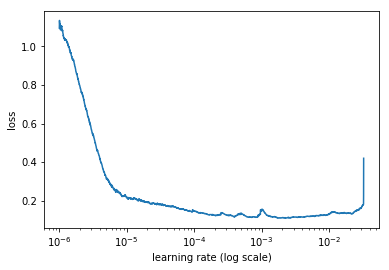

In [44]:
m.sched.plot(1)

In [ ]:
lr = 1e-6
m.fit(lrs=lr, n_cycle=3, metrics=[rmse], cycle_len=1, cycle_mult=2)


  0%|          | 3/7000 [00:01<45:08,  2.58it/s, loss=tensor(1.0498, device='cuda:0')]

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:49: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  return raw_loss.data[0]



  0%|          | 15/7000 [00:01<12:04,  9.64it/s, loss=tensor(1.1025, device='cuda:0')]

[0.      0.21745 0.2779  0.49928]                                                        A
[1.      0.174   0.20553 0.43676]                                                        
 36%|███▌      | 2506/7000 [00:39<01:10, 64.00it/s, loss=tensor(0.1715, device='cuda:0')]

In [ ]:
m.fit(lr, n_cycle=3, metrics=[rmse])

## Submit It!

In [ ]:
sample_subm.head()

In [ ]:
reload_test = pd.read_csv(f'{PATH}test.csv')

In [ ]:
apply_cats(reload_test, shops)
apply_cats(reload_test, items)

In [ ]:
reload_test.dtypes

In [ ]:
copy_test = test.copy()

In [ ]:
%%capture
ids_readded = pd.merge(reload_test, copy_test)

In [ ]:
assert not ids_readded.isnull().any().any()

In [ ]:
assert len(np.unique(ids_readded['ID'])) == len(ids_readded)

In [ ]:
ids_readded.head()

In [ ]:
ids_readded.head()

In [ ]:
test_df.head()

In [ ]:
result = m.predict(is_test=True)
predictions = np.expm1(result)
display(predictions)

In [ ]:
ids_readded['item_cnt_month'] = predictions

In [ ]:
final_dataframe = ids_readded[['ID', 'item_cnt_month']]

In [ ]:
final_dataframe.head()

In [ ]:
len(final_dataframe)

In [ ]:
len(np.unique(final_dataframe['ID']))

In [ ]:
SUBM = 'sub/'
os.makedirs(SUBM, exist_ok=True)
final_dataframe.to_csv(f'{SUBM}subm.gz', compression='gzip', index=False)

In [ ]:
FileLink(f'{SUBM}subm.gz')